In [1]:
import pandas as pd 
import matplotlib.pyplot as plt 
import math
import matplotlib.dates as mdates
import datetime as dt 

import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import * 
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit

from pandas.plotting import autocorrelation_plot

from pandas.plotting import lag_plot
from statsmodels.tsa.stattools import adfuller

import yfinance as yf
from pandas_datareader import data

import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA

2022-11-01 15:55:36.740541: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
aapl = yf.download('AAPL', start='2017-10-28', end='2022-10-28')
aapl


[*********************100%***********************]  1 of 1 completed


Open        High         Low       Close   Adj Close  \
Date                                                                     
2017-10-30   40.972500   42.017502   40.930000   41.680000   39.557045   
2017-10-31   41.974998   42.412498   41.735001   42.259998   40.107494   
2017-11-01   42.467499   42.485001   41.402500   41.722500   39.597382   
2017-11-02   41.650002   42.125000   41.320000   42.027500   39.886848   
2017-11-03   43.500000   43.564999   42.779999   43.125000   40.928444   
...                ...         ...         ...         ...         ...   
2022-10-21  142.869995  147.850006  142.649994  147.270004  147.270004   
2022-10-24  147.190002  150.229996  146.000000  149.449997  149.449997   
2022-10-25  150.089996  152.490005  149.360001  152.339996  152.339996   
2022-10-26  150.960007  151.990005  148.039993  149.350006  149.350006   
2022-10-27  148.070007  149.050003  144.130005  144.800003  144.800003   

               Volume  
Date                   
2017-10-30  178803200  
2017-10-31  144187200  
2017-11-01  134551200  
2017-11-02  165573600  
2017-11-03  237594400  
...               ...  
2022-10-21   86464700  
2022-10-24   75981900  
2022-10-25   74732300  
2022-10-26   88194300  
2022-10-27  109180200  

[1258 rows x 6 columns]

<AxesSubplot:xlabel='y(t)', ylabel='y(t + 1)'>

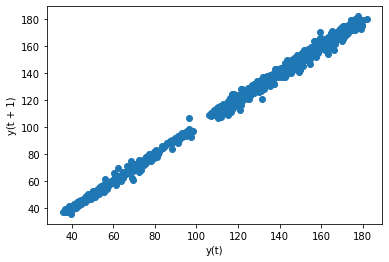

In [3]:
lag_plot(aapl.Close)

mean : 94.65841614764142


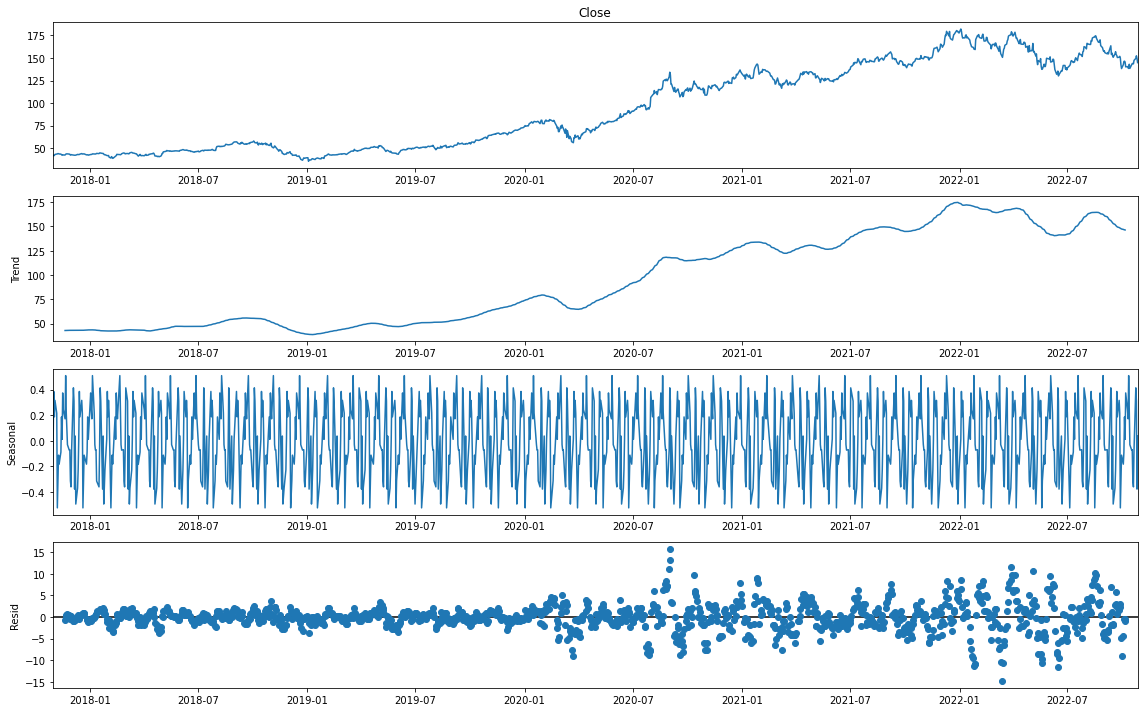

In [4]:
import statsmodels.api as sm
print('mean :' , aapl.Close.mean())
res = sm.tsa.seasonal_decompose(aapl.Close, period=30)
resplot = res.plot()
resplot.set_size_inches((16,10))
resplot.tight_layout()



<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

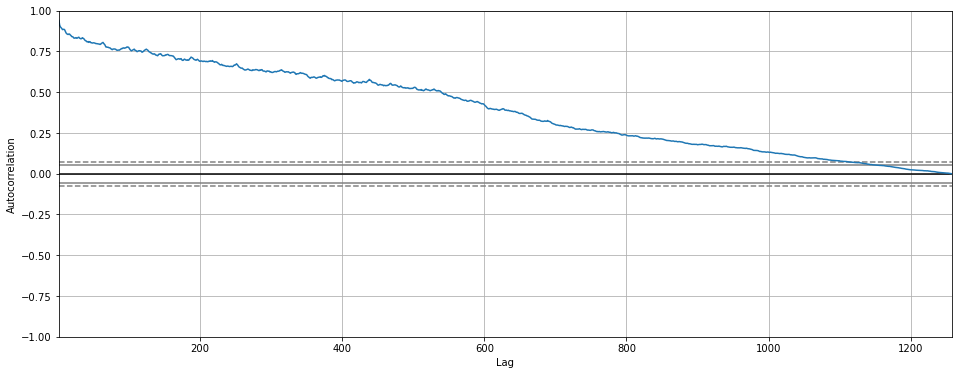

In [5]:
plt.figure(figsize=(16,6))
autocorrelation_plot(aapl)

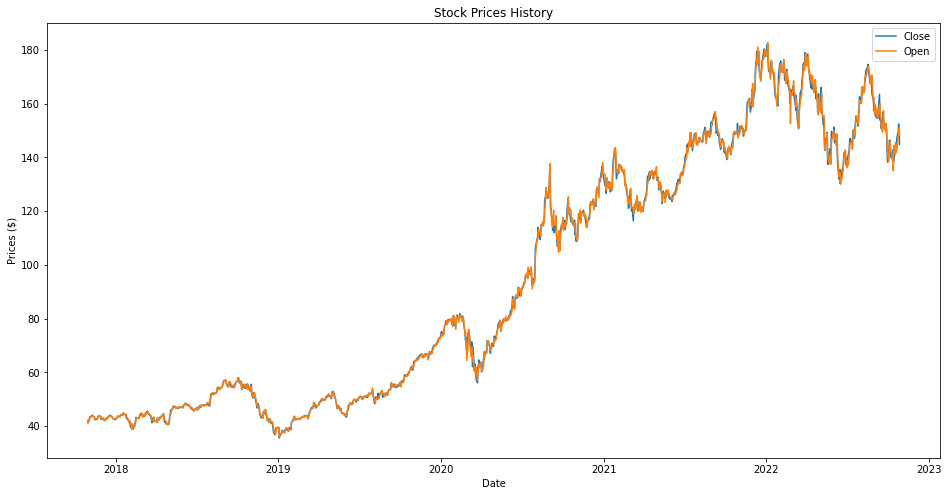

In [6]:
plt.figure(figsize=(16, 8))
plt.title('Stock Prices History')
plt.plot(aapl['Close'], label='Close')
plt.plot(aapl['Open'], label='Open')
plt.xlabel('Date')
plt.ylabel('Prices ($)')
plt.legend()

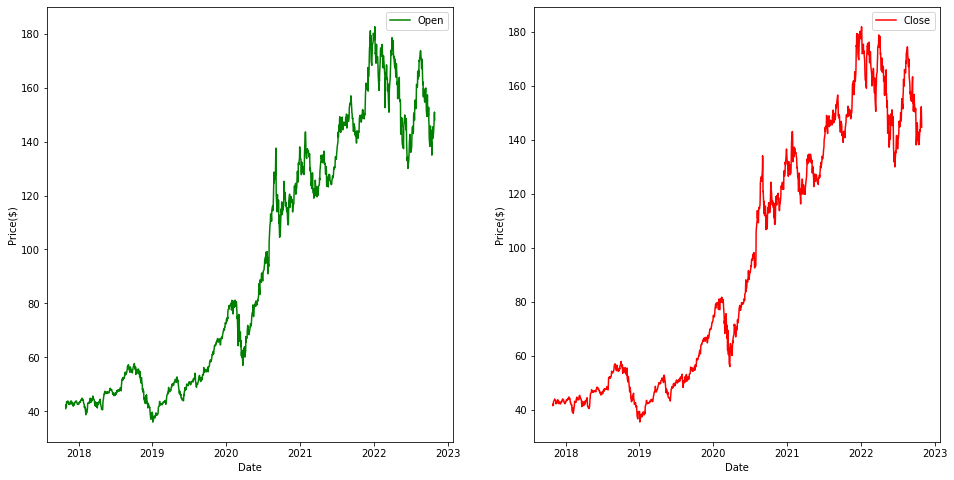

In [7]:
fg, ax =plt.subplots(1,2,figsize=(16,8))
ax[0].plot(aapl['Open'],label='Open',color='green')
ax[0].set_xlabel('Date',size=10)
ax[0].set_ylabel('Price($)',size=10)
ax[0].legend()
ax[1].plot(aapl['Close'],label='Close',color='red')
ax[1].set_xlabel('Date',size=10)
ax[1].set_ylabel('Price($)',size=10)
ax[1].legend()
plt.show()

In [8]:
close_prices = aapl['Close']
values = close_prices.values
training_data_len = math.ceil(len(values)* 0.8)

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(values.reshape(-1,1))

train_data = scaled_data[0: training_data_len, :]

x_train = []
y_train = []

for i in range(750, len(train_data)):
    x_train.append(train_data[i-750:i, 0])
    y_train.append(train_data[i, 0])
    
x_train, y_train = np.array(x_train), np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))


test_data = scaled_data[training_data_len-750: , : ]
x_test = []
y_test = values[training_data_len:]

for i in range(750, len(test_data)):
    x_test.append(test_data[i-750:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [14]:
%%time
model = keras.Sequential()
model.add(layers.LSTM(100, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(layers.LSTM(100, return_sequences=True))
model.add(Dropout(0.2))
model.add(layers.LSTM(100, return_sequences=False))
model.add(Dropout(0.2))

model.add(layers.Dense(100))
model.add(layers.Dense(50))
model.add(layers.Dense(25))
model.add(layers.Dense(1))
model.summary()



Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 750, 100)          40800     
                                                                 
 dropout_3 (Dropout)         (None, 750, 100)          0         
                                                                 
 lstm_4 (LSTM)               (None, 750, 100)          80400     
                                                                 
 dropout_4 (Dropout)         (None, 750, 100)          0         
                                                                 
 lstm_5 (LSTM)               (None, 100)               80400     
                                                                 
 dropout_5 (Dropout)         (None, 100)               0         
                                                                 
 dense_4 (Dense)             (None, 100)              

In [15]:
%%time
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, batch_size= 32, epochs=50)

Epoch 1/50
9/9 [==============================] - 13s 994ms/step - loss: 0.0985
Epoch 2/50
9/9 [==============================] - 9s 993ms/step - loss: 0.0134
Epoch 3/50
9/9 [==============================] - 9s 1s/step - loss: 0.0074
Epoch 4/50
9/9 [==============================] - 9s 1s/step - loss: 0.0041
Epoch 5/50
9/9 [==============================] - 9s 1s/step - loss: 0.0041
Epoch 6/50
9/9 [==============================] - 9s 995ms/step - loss: 0.0033
Epoch 7/50
9/9 [==============================] - 10s 1s/step - loss: 0.0038
Epoch 8/50
9/9 [==============================] - 9s 1s/step - loss: 0.0033
Epoch 9/50
9/9 [==============================] - 11s 1s/step - loss: 0.0040
Epoch 10/50
9/9 [==============================] - 10s 1s/step - loss: 0.0044
Epoch 11/50
9/9 [==============================] - 9s 1s/step - loss: 0.0048
Epoch 12/50
9/9 [==============================] - 9s 1s/step - loss: 0.0046
Epoch 13/50
9/9 [==============================] - 9s 1s/step - loss: 0.

In [16]:
%%time
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)
rmse = np.sqrt(np.mean(predictions - y_test)**2)
rmse

8/8 [==============================] - 3s 281ms/step
CPU times: user 7.2 s, sys: 1.86 s, total: 9.07 s
Wall time: 3.27 s


1.2297869070592629

<timed exec>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


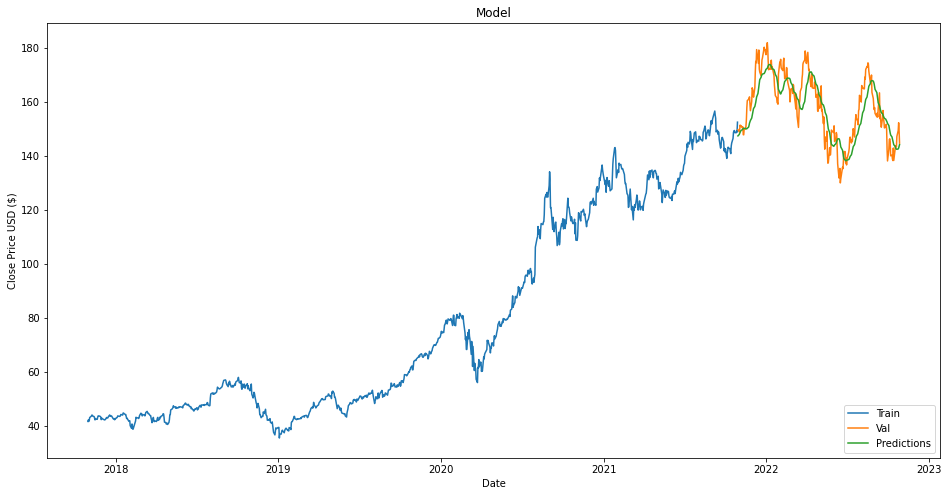

CPU times: user 234 ms, sys: 154 ms, total: 388 ms
Wall time: 534 ms


In [17]:
%%time
data = aapl.filter(['Close'])
train = data[:training_data_len]
validation = data[training_data_len:]
validation['Predictions'] = predictions
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.plot(train)
plt.plot(validation[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

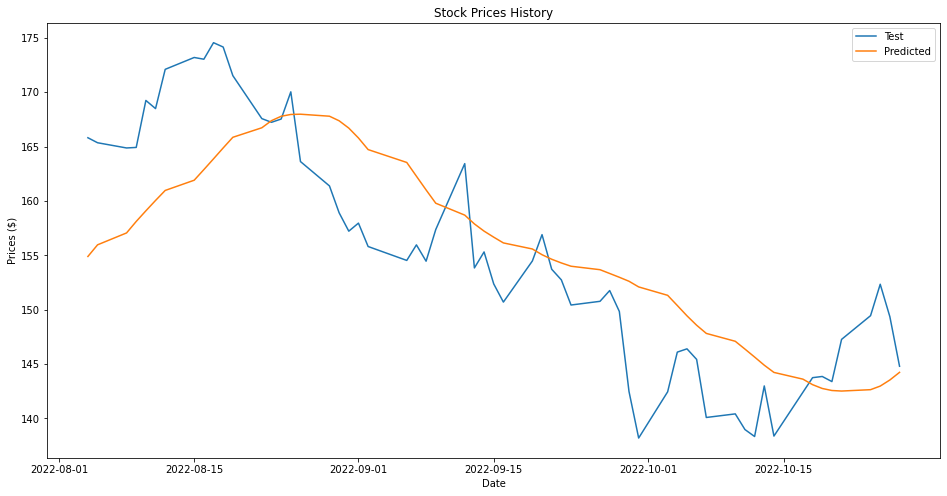

In [18]:
plt.figure(figsize=(16, 8))
plt.title('Stock Prices History')
plt.plot(validation['Close'].iloc[-60:], label='Test')
plt.plot(validation['Predictions'].iloc[-60:], label='Predicted')
plt.xlabel('Date')
plt.ylabel('Prices ($)')
plt.legend()

# graphing just last 60 days of test vs predictions 

In [25]:
from pandas import Timestamp
start = Timestamp('2000-01-01')
end = Timestamp('2022-10-31')

all_dates = pd.date_range(start=start, end=end, freq='B')

# You can fill the "Value" column with any value you want. Here I filled with 0.
future = pd.DataFrame({'Date':all_dates , 'Value':[0]*len(all_dates)})
# future

future.index = pd.DatetimeIndex(future.Date, freq=None)
future



Date  Value
Date                        
2000-01-03 2000-01-03      0
2000-01-04 2000-01-04      0
2000-01-05 2000-01-05      0
2000-01-06 2000-01-06      0
2000-01-07 2000-01-07      0
...               ...    ...
2022-10-25 2022-10-25      0
2022-10-26 2022-10-26      0
2022-10-27 2022-10-27      0
2022-10-28 2022-10-28      0
2022-10-31 2022-10-31      0

[5956 rows x 2 columns]

In [19]:
from pandas import Timestamp
start = Timestamp('2022-10-27')
end = Timestamp('2022-10-27')

all_dates = pd.date_range(start=start, end=end, freq='D')

# You can fill the "Value" column with any value you want. Here I filled with 0.
future = pd.DataFrame({'Date':all_dates , 'Value':[0]*len(all_dates)})
# future

future.index = pd.DatetimeIndex(future.Date, freq=None)
# future

future = future.drop(['Date'], axis=1)
future

Value
Date             
2022-10-27      0

In [20]:
futurepredictions = model.predict(future)
futurepredictions = scaler.inverse_transform(futurepredictions)

1/1 [==============================] - 1s 1s/step


In [21]:
futurepredictions

array([[95.84532]], dtype=float32)